In [2]:
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

# Argmax and Hidden Biases

----------------------------------

Debugging deep learning models (and most of other ML models for that matter) can be really painful. Because of their probabilistic nature they often produce the worst kind of bugs: the model executes without any exceptions and results are reasonable most of the time, but *sometimes* the model spits out utter gibberish. And tracing down sources of these occasional errors can take hours or even days. So today I wanna share one debugging story so people can learn from my mistakes rather than from their own.

While working on a face parsing project with my fellow colleagues we encountered a problem: a custom trained face parser was sporadically flickering on videos - switching left and right eyes randomly. However, on a test set it performed reasonably well. As we didn't observe this problem on still images, we suspected that it has something to do with video consistency and tested various filtering methods to fix it. Filtering reduced left-right flickering to a degree but nearly  enough. We considered adding additional post-processing heuristics to separate left and right eyes, adding pretrained keypoint estimators to the pipeline and even to relax the requirements and merge them into a single class. But luckily the source of the problem has been found.

# The Root of All Evil

As it always turns out, the mistake was embarrassingly dumb and was hiding in the plain sight all along. All the results, and metrics for the face parser were reported ***after*** the argmax layer on top, which is kinda common thing to do. The problem with the argmax, however, is that it doesn't care if the maximum value differs by 0.1 or by 0.001 - it destroys information. Take a look at these two predictions:

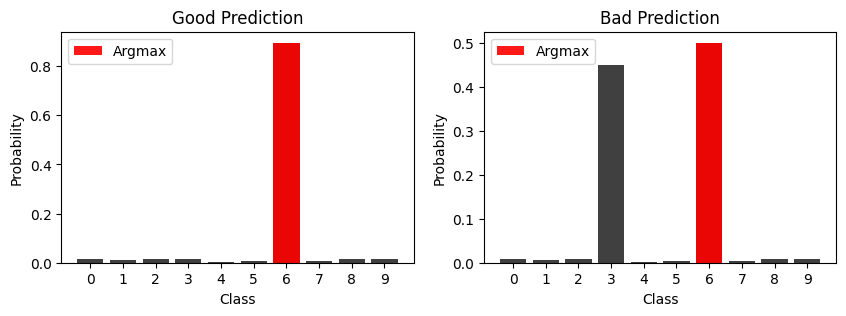

In [2]:
torch.random.manual_seed(42)
x = torch.randn(10)

plt.figure(figsize = (10,3))

plt.subplot(1,2,1)
x[6] *= 2
p = torch.softmax(x, 0)
z = np.zeros(10)
z[6] = p[6]

plt.title('Good Prediction')
plt.bar(np.arange(10), p, color = 'k', alpha = 0.75)
plt.bar(np.arange(10), z, color = 'r', alpha = 0.9, label = 'Argmax')
plt.xticks(np.arange(10))
plt.xlabel('Class')
plt.ylabel('Probability')
plt.legend(loc = 2)

plt.subplot(1,2,2)
x[3] *= 18.7
p = torch.softmax(x, 0)
z = np.zeros(10)
z[6] = p[6]

plt.title('Bad Prediction')
plt.bar(np.arange(10), p, color = 'k', alpha = 0.75)
plt.bar(np.arange(10), z, color = 'r', alpha = 0.9, label = 'Argmax')
plt.xticks(np.arange(10))
plt.xlabel('Class')
plt.ylabel('Probability')
plt.legend(loc = 2);

The first one is what people usually wanna get, the second one - meh. But if we were looking at argmax value only, we would get index 6 in both cases and any information about confidence of the prediction would be lost. This is exactly what happened to our face parser but worse. The left/right eye classes had largest probability most of the time so these classes were argmaxed correctly:

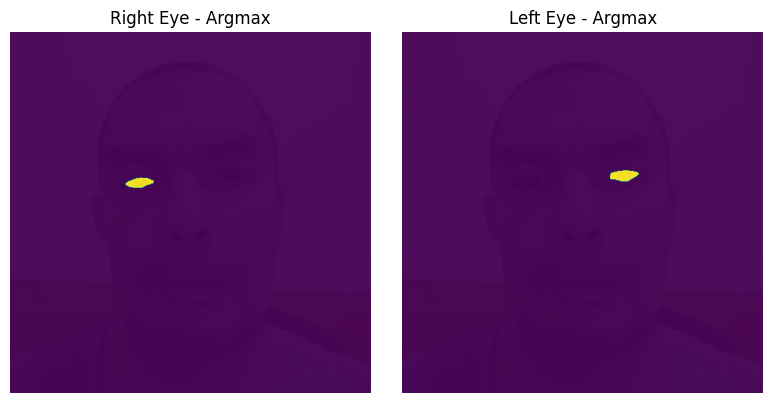

In [3]:
Image.open("assets/argmax_and_hidden_biases/argmax_demo.png")

I would go to a nearest crossroads and sign a deal with the Devil to get such accurate segmentation masks all the time. And the Devil definitely played his tricks on us, as he usually does, because these nice masks were hiding this under the argmax:

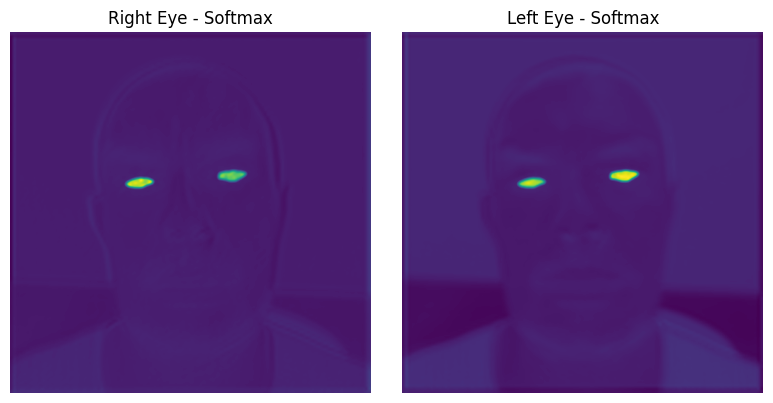

In [4]:
Image.open('assets/argmax_and_hidden_biases/probs_demo.png')

So despite the correct masks our model had actually little to no distinction between left and right eyes whatsoever! After examining more images we found out that this is a systematic behavior, so definitely something was wrong with our training setup. These kinds of problems are much easier to track down than occasional errors. As you can guess, the problem was hiding in the augmentation pipeline. There was a random flip augmentation but due to a mistake in the code labels weren't changed from left to right correctly. Additionally, due to augmentation probabilities, this mistake didn't appear all the time so predictions were *almost* correct. The model averaged everything out and developed a strong bias towards left-right indifference. Obviously, after fixing this mistake with augmentations the problem went away, the network learnt to tell left from right and flickering on videos disappeared. 

# Conclusion

Argmax is a trick of the Devil: its robustness to small errors in probability predictions (when they are confident) is its blessing but also a curse as it can confuse strong biases of the model with a noise. So yeah, don't forget to check your probs, I guess.